In [7]:
import tabs
import pandas as pd

import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
%matplotlib inline

# TABS data

You can read in the metadata for a buoy with buoymeta = tabs.meta(BUOYNAME), then access it as columns in a dataframe. For example, you can get the longitude and latitude for buoy 8771013 with the following:

>meta = tabs.meta('8771013')

>meta[['lon','lat']]

The basic call to get buoy data is

> tabs.read(BUOYNAME, DATETIME START STRING, DATETIME END STRING)

and returns a pandas dataframe. Missing values are filled in with np.nan. If data is not available, None is returned and exception is printed. Column names describe data and units and are prepended with station name followed by a colon.

The date/time strings have to be interpretable by pandas Timestamp function.

Available data stations are:

Any station listed on the TABS website: http://pong.tamu.edu/tabswebsite.
Texas Water Development Board coastal time series data: http://waterdatafortexas.org/coastal
Any USGS stream gauges. A nice website is available that shows the Texas stations: https://txpub.usgs.gov/txwaterdashboard/index.html
Model output from a ROMS model of the Texas and Louisiana continental shelves and from NOAA is available at many of the stations listed on the TABS website, as visible on the buoy listing on the front page.

In [36]:
fsmed = 12

merc = cartopy.crs.Mercator(central_longitude=-85.0)
pc = cartopy.crs.PlateCarree()
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
states_provinces = cartopy.feature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

figextent = [-99, -86, 24, 31]

In [3]:
buoys = tabs.buoylist()

In [39]:
meta = tabs.meta(buoys)
ll = meta[['lon','lat']]

## Plot buoy locations

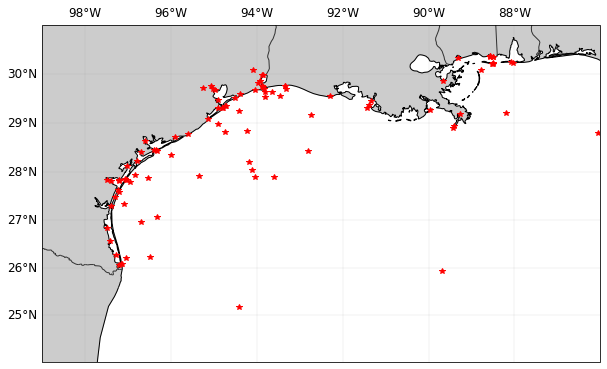

In [40]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=merc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': fsmed}
gl.ylabel_style = {'fontsize': fsmed}
gl.bottom_labels = False  # turn off labels where you don't want them
gl.right_labels = False
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_extent(figextent, pc)

ax.plot(ll['lon'], ll['lat'], 'r*', transform=pc)

## Data sources



### TABS

Read in all available types of data (which will include all of or a subset of: currents, temperature, salinity, winds, air temperature, and wave data) for a TABS buoy over a given time range. Data is resampled to every half hour by default since different instruments are available at different rates. This can be overridden with user-input resample choices.

> df = tabs.read('B', '2018-1-1', '2018-1-10')

<AxesSubplot:>

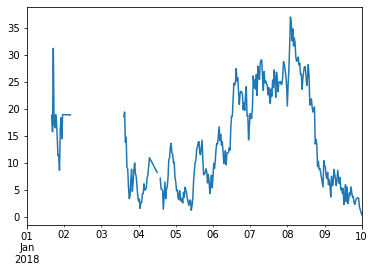

In [47]:
df = tabs.read('B', '2018-1-1', '2018-1-10')
df['B: Speed [cm/s] (water)'].plot()

### PORTS

Read in PORTS data (currents) from Texas and Louisiana area. Can include time if desired:

> df = tabs.read('g06010', '2017-7-1', '2017-7-10 12:00')

<AxesSubplot:xlabel='Dates [UTC]'>

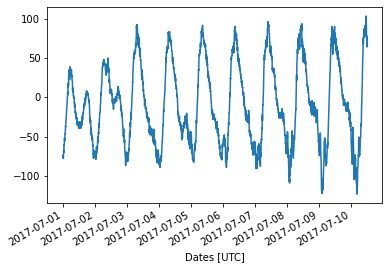

In [49]:
df = tabs.read('g06010', '2017-7-1', '2017-7-10 12:00')
df['g06010: Along [cm/s] (water)'].plot()

### Full PORTS ADCP

Read in full ADCP data for PORTS stations, which is either with depth or cross-channel. This data has a matching time stamp for each depth or cross-channel bin.

> df = tabs.read('g06010_full', '2017-7-1', '2017-7-10')

In [50]:
df = tabs.read('g06010_full', '2017-7-1', '2017-7-10')

A specific depth (in this example -4.31 m) or cross-channel bin can subsequently selected from a full ADCP profile with the following, with the column name 'Depth to center of bin [m]' for ADCP data with depth or 'Distance to center of bin [m]' for ADCP data across a channel:

<AxesSubplot:xlabel='Dates [UTC]'>

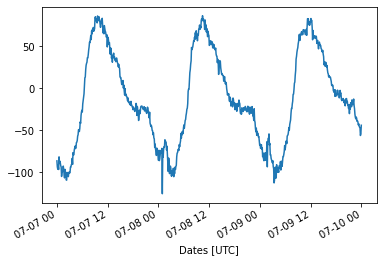

In [57]:
df[df['Depth to center of bin [m]'] == -4.31]['Along [cm/s] (water)'].plot()

Plot a specific water column or transect (as the case may be) of PORTS data:

<AxesSubplot:xlabel='Along [cm/s] (water)'>

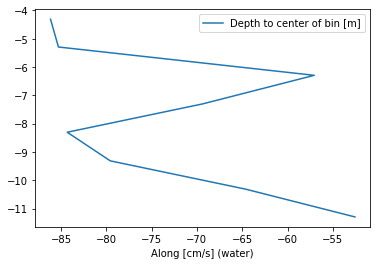

In [69]:
df.loc[df.index[0],:].plot(y='Depth to center of bin [m]', x='Along [cm/s] (water)')

### NDBC

Read in NDBC data (usually met data, some wave data is available) from the area:

> df = tabs.read('42001', '2018-5-25 4:00', '2018-6-7 12:00')

<AxesSubplot:xlabel='Dates [UTC]'>

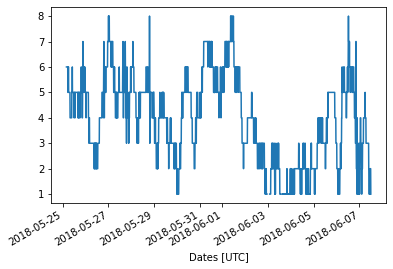

In [75]:
df = tabs.read('42001', '2018-5-25 4:00', '2018-6-7 12:00')
df['42001: Speed [m/s] (air)'].plot()

### TCOON

Read in data from a TCOON buoy (typically sea surface height, met data, water temperature). For any buoy with sea surface height data near the coast, you can select a different vertical datum from the default of Mean Sea Level:

> df = tabs.read('8770475', '2017-1-1', '2017-1-10', datum='MSL')

<AxesSubplot:xlabel='Dates [UTC]'>

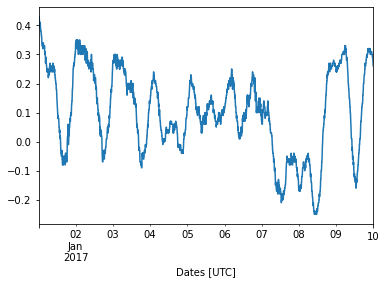

In [84]:
df = tabs.read('8771972', '2017-1-1', '2017-1-10', datum='MSL')
df['8771972: Water Level [m, MSL]'].plot()

### NOS

Read in other NOS buoy (similar to TCOON buoys):

> df = tabs.read('8770570', '2017-1-1', '2017-1-10')

<AxesSubplot:xlabel='Dates [UTC]'>

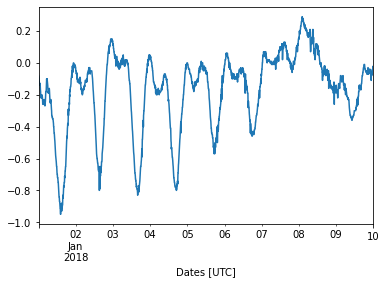

In [89]:
df = tabs.read('8770570', '2018-1-1', '2018-1-10')
df['8770570: Water Level [m, MSL]'].plot()

### TWDB

Read in Texas Water Development Board time series data. All available data from salinity, temperature, depth, turbidity, Ph, and dissolved oxygen concentration will be read in. If dstart is None, all available data will be read in. If given, the file will be subsetted before being returned. Binning of data can be 'mon' (monthly), 'day' (daily), 'hour' (hourly), 'min' (minutes); default 'hour'. If selected binning is not available for all datatypes for station, they will not be returned. Long term station data should be available (https://www.waterdatafortexas.org/coastal).

> df = tabs.read('BOLI')

In [90]:
df = tabs.read('BOLI')

HTTP Error 500: INTERNAL SERVER ERROR


<AxesSubplot:xlabel='Dates [UTC]'>

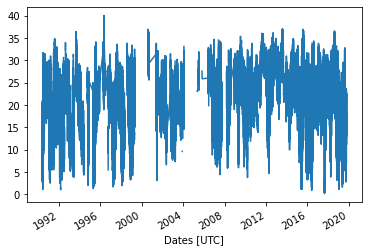

In [92]:
df['BOLI: Salinity'].plot()

### USGS

Read in data from a USGS station, or a list of stations. Input freq can be 'iv' (default) for instantaneous flow rate readings or 'dv' for daily values. Daily values are not available for all variables and stations. Input var can be 'flow' (default) for stream flow data in m^3/s, 'height' for gauge height data in m, or 'storage' for reservoir storage in m^3. Not all stations have all variables.

> df = tabs.read('08042558', '2018-6-1', '2018-6-7', var='height')

> df = tabs.read(['08042558','08116650'], '2017-1-1', '2017-1-10', var='height')

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=08042558%2C08116650&parameterCd=00065&startDT=2017-01-01&endDT=2017-01-10


<AxesSubplot:xlabel='Dates [UTC]'>

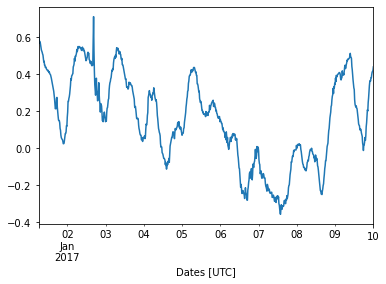

In [9]:
df = tabs.read(['08042558','08116650'], '2017-1-1', '2017-1-10', var='height')
df['08042558: Gage height [m]'].plot()

### TXLA Model

Read in time series output from numerical model of Texas-Louisiana shelf at a station available on the TABS website, including a depth index for variables s_rho of between 0 and 29, with -1 as the surface (default) or -999 for all available depths:

> df = tabs.read('B', '2018-6-2', '2018-6-10', model=True, s_rho=10)

In [10]:
df = tabs.read('B', '2018-6-2', '2018-6-10', model=True, s_rho=10)
df

Dataframe was empty. Maybe the requested time series is not available for this time period.


### NOAA Model

Read in time series output available from a NOAA model for coastal tidal stations, for either sea surface height or tidal currents at some PORTS stations. This is available for 2 years before and after present day:

> df = tabs.read('8771972', '2018-6-2', '2018-6-10', model=True)

<AxesSubplot:xlabel='Dates [UTC]'>

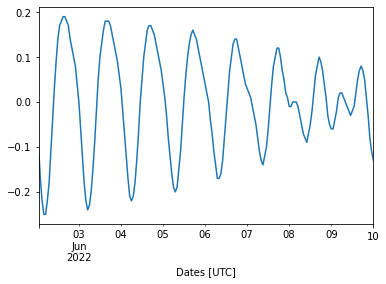

In [12]:
df = tabs.read('8771972', '2022-6-2', '2022-6-10', model=True)
df['8771972: Water Level [m, MSL]'].plot()

## Example utilities

### Combine dataframes

After reading in different data, can combine dataframes:

> df = tabs.read('BOLI')

> df = df.join(tabs.read('EAST'), how='outer')

In [13]:
df = tabs.read('BOLI')
df = df.join(tabs.read('EAST'), how='outer')
df

HTTP Error 500: INTERNAL SERVER ERROR
HTTP Error 500: INTERNAL SERVER ERROR
HTTP Error 500: INTERNAL SERVER ERROR


,BOLI: Salinity,BOLI: Depth [m],BOLI: WaterT [deg C],BOLI: Dissolved oxygen concentration [mgl],BOLI: Dissolved oxygen saturation concentration [%],BOLI: pH level,EAST: Salinity,EAST: Depth [m],EAST: WaterT [deg C],EAST: Dissolved oxygen concentration [mgl],EAST: pH level
Dates [UTC],,,,,,,,,,,
1990-05-15 21:00:00+00:00,20.417000,NaN,25.390000,7.19,NaN,8.25,NaN,NaN,NaN,NaN,NaN
1990-05-15 22:00:00+00:00,20.210000,NaN,25.720000,7.36,NaN,8.28,NaN,NaN,NaN,NaN,NaN
1990-05-16 00:00:00+00:00,19.319000,NaN,26.100000,7.66,NaN,8.30,NaN,NaN,NaN,NaN,NaN
1990-05-16 01:00:00+00:00,19.114000,NaN,26.020000,7.84,NaN,8.32,NaN,NaN,NaN,NaN,NaN
1990-05-16 03:00:00+00:00,19.045000,NaN,25.930000,7.41,NaN,8.29,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-18 12:00:00+00:00,22.416238,3.353210,24.299316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-18 13:00:00+00:00,22.418591,3.334595,24.664612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-18 14:00:00+00:00,22.200020,3.228821,24.366150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Resampling

You can choose to have the data resampled with the keyword argument resample. resample will interpolate to upsample or take the average to downsample data. If used, input a tuple with the desired frequency of data, the base value, and whether you want an instantaneous approximation or an average. The code will figure out if this is down- or up-sampling. If it is upsampling, instantaneous is your only reasonable choice. For example, `resample=('15T',0,'instant',False)` for resampling to 15 minutes starting at 0 minutes on the hour and will interpolate to find the instantaneous value between given values; the time label will match the input time. `resample=('15T',0,'mean',True)` will take an average of values and only makes sense if downsampling. The resulting time series will be labeled at the middle of the time interval that a mean was taken over, if a mean was taken and if `resample[3]==True`. If `resample[3]==False`, the time label will instead be at the left end of the time window.

> df = tabs.read('g06010', '2012-3-1', '2012-3-10', resample=('15T', 0, 'mean'))

In [15]:
df = tabs.read('g06010', '2012-3-1', '2012-3-10', resample=('15T', 0, 'mean', True))
df

/Users/kthyng/projects/tabs/tabs.py:211: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  df = df.resample(resample[0], base=resample[1], label='left', loffset=loffset).mean()
/Users/kthyng/projects/tabs/tabs.py:211: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df = df.resample(resample[0], base=resample[1], label='left', loffset=loffset).mean()


,g06010: Speed [cm/s] (water),g06010: Dir [deg T] (water),g06010: Along [cm/s] (water),g06010: Across [cm/s] (water)
Dates [UTC],,,,
2012-03-01 00:07:30+00:00,9.800000,41.000000,-7.720,-6.030000
2012-03-01 00:22:30+00:00,15.300000,71.500000,-14.955,-1.265000
2012-03-01 00:37:30+00:00,16.800000,73.000000,-16.690,-1.735000
2012-03-01 00:52:30+00:00,18.500000,80.000000,-18.500,0.320000
2012-03-01 01:07:30+00:00,21.800000,70.000000,-21.525,-3.405000
...,...,...,...,...
2012-03-09 22:52:30+00:00,78.866667,270.333333,77.320,-15.440000
2012-03-09 23:07:30+00:00,69.200000,268.500000,68.230,-11.410000
2012-03-09 23:22:30+00:00,67.766667,272.000000,65.960,-15.343333


### Time zone

The default time zone is UTC, but you can instead choose 'US/Central' with the tz keyword argument as follows:

> df = tabs.read('F', '2010-5-23', '2010-5-30', tz='US/Central')

In [16]:
df = tabs.read('F', '2010-5-23', '2010-5-30', tz='US/Central')
df

,F: Dates [UTC],F: WaterT [deg C] (microcat),F: Cond [ms/cm],F: Salinity,F: Density [kg/m^3],F: SoundVel [m/s] (air),F: East [cm/s] (water),F: North [cm/s] (water),F: WaterT [deg C] (dcs),F: Tx,F: Ty,F: Speed [cm/s] (water),F: Across [cm/s] (water),F: Along [cm/s] (water),F: Dir [deg T] (water)
2010-05-23 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-9.150,8.420,26.330,2.0,-2.0,12.430,-11.500,-4.730,313.0
2010-05-23 00:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-8.355,6.955,26.315,1.5,-1.5,10.885,-9.835,-4.630,309.5
2010-05-23 01:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-7.560,5.490,26.300,1.0,-1.0,9.340,-8.170,-4.530,306.0
2010-05-23 01:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-9.305,4.840,26.285,1.5,-1.5,10.580,-8.320,-6.385,298.5
2010-05-23 02:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,-11.050,4.190,26.270,2.0,-2.0,11.820,-8.470,-8.240,291.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-29 22:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,4.020,16.810,28.090,0.0,0.0,17.280,-13.540,10.750,13.0
2010-05-29 22:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,3.635,19.790,28.135,0.5,0.0,20.140,-16.400,11.660,10.5
2010-05-29 23:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,3.250,22.770,28.180,1.0,0.0,23.000,-19.260,12.570,8.0
2010-05-29 23:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,2.785,25.355,28.180,1.5,0.5,25.520,-21.800,13.240,6.5


## Basic Pandas commands

### Plotting

You can easily plot with pandas. After reading in a dataset to df; note that the plot command will take many matplotlib keyword arguments:

> df.plot()

<AxesSubplot:>

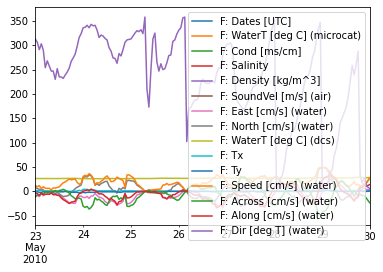

In [17]:
df.plot()

### Selecting data

You can select from one date to another of your dataset using date strings

> df['2017-1-1':'2017-1-5']

You can also pull out one or more columns:

> df['column name']

> df[['column1', 'column2']]

### Save data

You can export your dataframe to a csv file with:

> df.to_csv('filename.csv')

### Time zone

You can remove the timezone information on the datetimes but retain the timezone with:

> df.tz_localize(None)